
##Setup

You will need to make a copy of this Colab notebook in your Google Drive before you can edit the homework files. You can do so with **File &rarr; Save a copy in Drive**.


In [ ]:
import os
from google_drive_downloader import GoogleDriveDownloader as gdd

# Need to download the Omniglot dataset -- DON'T MODIFY THIS CELL
if not os.path.isdir('./omniglot_resized'):
    gdd.download_file_from_google_drive(file_id='1iaSFXIYC3AB8q9K_M-oVMa4pmB7yKMtI',
                                        dest_path='./omniglot_resized.zip',
                                        unzip=True)

assert os.path.isdir('./omniglot_resized')

Unzipping...Done.


In [ ]:
""" Utility functions. """
## NOTE: You do not need to modify this block but you will need to use it.
import numpy as np
import os
import random
import tensorflow as tf

## Loss utilities
def cross_entropy_loss(pred, label, k_shot):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=tf.stop_gradient(label)) / k_shot)

def accuracy(labels, predictions):
  return tf.reduce_mean(tf.cast(tf.equal(labels, predictions), dtype=tf.float32))
    

In [ ]:
"""Convolutional layers used by MAML model."""
## NOTE: You do not need to modify this block but you will need to use it.
seed = 123
def conv_block(inp, cweight, bweight, bn, activation=tf.nn.relu, residual=False):
  """ Perform, conv, batch norm, nonlinearity, and max pool """
  stride, no_stride = [1,2,2,1], [1,1,1,1]

  conv_output = tf.nn.conv2d(input=inp, filters=cweight, strides=no_stride, padding='SAME') + bweight
  normed = bn(conv_output)
  normed = activation(normed)
  return normed

class ConvLayers(tf.keras.layers.Layer):
  def __init__(self, channels, dim_hidden, dim_output, img_size):
    super(ConvLayers, self).__init__()
    self.channels = channels
    self.dim_hidden = dim_hidden
    self.dim_output = dim_output
    self.img_size = img_size

    weights = {}

    dtype = tf.float32
    weight_initializer =  tf.keras.initializers.GlorotUniform()
    k = 3

    weights['conv1'] = tf.Variable(weight_initializer(shape=[k, k, self.channels, self.dim_hidden]), name='conv1', dtype=dtype)
    weights['b1'] = tf.Variable(tf.zeros([self.dim_hidden]), name='b1')
    self.bn1 = tf.keras.layers.BatchNormalization(name='bn1')
    weights['conv2'] = tf.Variable(weight_initializer(shape=[k, k, self.dim_hidden, self.dim_hidden]), name='conv2', dtype=dtype)
    weights['b2'] = tf.Variable(tf.zeros([self.dim_hidden]), name='b2')
    self.bn2 = tf.keras.layers.BatchNormalization(name='bn2')
    weights['conv3'] = tf.Variable(weight_initializer(shape=[k, k, self.dim_hidden, self.dim_hidden]), name='conv3', dtype=dtype)
    weights['b3'] = tf.Variable(tf.zeros([self.dim_hidden]), name='b3')
    self.bn3 = tf.keras.layers.BatchNormalization(name='bn3')
    weights['conv4'] = tf.Variable(weight_initializer([k, k, self.dim_hidden, self.dim_hidden]), name='conv4', dtype=dtype)
    weights['b4'] = tf.Variable(tf.zeros([self.dim_hidden]), name='b4')
    self.bn4 = tf.keras.layers.BatchNormalization(name='bn4')
    weights['w5'] = tf.Variable(weight_initializer(shape=[self.dim_hidden, self.dim_output]), name='w5', dtype=dtype)
    weights['b5'] = tf.Variable(tf.zeros([self.dim_output]), name='b5')
    self.conv_weights = weights

  def call(self, inp, weights):
    channels = self.channels
    inp = tf.reshape(inp, [-1, self.img_size, self.img_size, channels])
    hidden1 = conv_block(inp, weights['conv1'], weights['b1'], self.bn1)
    hidden2 = conv_block(hidden1, weights['conv2'], weights['b2'], self.bn2)
    hidden3 = conv_block(hidden2, weights['conv3'], weights['b3'], self.bn3)
    hidden4 = conv_block(hidden3, weights['conv4'], weights['b4'], self.bn4)
    hidden4 = tf.reduce_mean(input_tensor=hidden4, axis=[1, 2])
    return tf.matmul(hidden4, weights['w5']) + weights['b5']

In [ ]:
"""Data loading scripts"""
## NOTE: You do not need to modify this block but you will need to use it.
import numpy as np
import os
import random
import tensorflow as tf
from scipy import misc
import imageio

def get_images(paths, labels, n_samples=None, shuffle=True):
  """
  Takes a set of character folders and labels and returns paths to image files
  paired with labels.
  Args:
    paths: A list of character folders
    labels: List or numpy array of same length as paths
    n_samples: Number of images to retrieve per character
  Returns:
    List of (label, image_path) tuples
  """
  if n_samples is not None:
    sampler = lambda x: random.sample(x, n_samples)
  else:
    sampler = lambda x: x
  images_labels = [(i, os.path.join(path, image))
           for i, path in zip(labels, paths)
           for image in sampler(os.listdir(path))]
  if shuffle:
    random.shuffle(images_labels)
  return images_labels


def image_file_to_array(filename, dim_input):
  """
  Takes an image path and returns numpy array
  Args:
    filename: Image filename
    dim_input: Flattened shape of image
  Returns:
    1 channel image
  """
  image = imageio.imread(filename)
  image = image.reshape([dim_input])
  image = image.astype(np.float32) / 255.0
  image = 1.0 - image
  return image


class DataGenerator(object):
  """
  Data Generator capable of generating batches of Omniglot data.
  A "class" is considered a class of omniglot digits.
  """

  def __init__(self, num_classes, num_samples_per_class, num_meta_test_classes, num_meta_test_samples_per_class, config={}):
    """
    Args:
      num_classes: Number of classes for classification (K-way)
      num_samples_per_class: num samples to generate per class in one batch
      num_meta_test_classes: Number of classes for classification (K-way) at meta-test time
      num_meta_test_samples_per_class: num samples to generate per class in one batch at meta-test time
      batch_size: size of meta batch size (e.g. number of functions)
    """
    self.num_samples_per_class = num_samples_per_class
    self.num_classes = num_classes
    self.num_meta_test_samples_per_class = num_meta_test_samples_per_class
    self.num_meta_test_classes = num_meta_test_classes

    data_folder = config.get('data_folder', './omniglot_resized')
    self.img_size = config.get('img_size', (28, 28))

    self.dim_input = np.prod(self.img_size)
    self.dim_output = self.num_classes

    character_folders = [os.path.join(data_folder, family, character)
               for family in os.listdir(data_folder)
               if os.path.isdir(os.path.join(data_folder, family))
               for character in os.listdir(os.path.join(data_folder, family))
               if os.path.isdir(os.path.join(data_folder, family, character))]

    random.seed(123)
    random.shuffle(character_folders)
    num_val = 100
    num_train = 1100
    self.metatrain_character_folders = character_folders[: num_train]
    self.metaval_character_folders = character_folders[
      num_train:num_train + num_val]
    self.metatest_character_folders = character_folders[
      num_train + num_val:]

  def sample_batch(self, batch_type, batch_size, shuffle=True, swap=False):
    """
    Samples a batch for training, validation, or testing
    Args:
      batch_type: meta_train/meta_val/meta_test
      shuffle: randomly shuffle classes or not
      swap: swap number of classes (N) and number of samples per class (K) or not
    Returns:
      A a tuple of (1) Image batch and (2) Label batch where
      image batch has shape [B, N, K, 784] and label batch has shape [B, N, K, N] if swap is False
      where B is batch size, K is number of samples per class, N is number of classes
    """
    if batch_type == "meta_train":
      folders = self.metatrain_character_folders
      num_classes = self.num_classes
      num_samples_per_class = self.num_samples_per_class
    elif batch_type == "meta_val":
      folders = self.metaval_character_folders
      num_classes = self.num_classes
      num_samples_per_class = self.num_samples_per_class
    else:
      folders = self.metatest_character_folders
      num_classes = self.num_meta_test_classes
      num_samples_per_class = self.num_meta_test_samples_per_class
    all_image_batches, all_label_batches = [], []
    for i in range(batch_size):
      sampled_character_folders = random.sample(
        folders, num_classes)
      labels_and_images = get_images(sampled_character_folders, range(
        num_classes), n_samples=num_samples_per_class, shuffle=False)
      labels = [li[0] for li in labels_and_images]
      images = [image_file_to_array(
        li[1], self.dim_input) for li in labels_and_images]
      images = np.stack(images)
      labels = np.array(labels).astype(np.int32)
      labels = np.reshape(
        labels, (num_classes, num_samples_per_class))
      labels = np.eye(num_classes, dtype=np.float32)[labels]
      images = np.reshape(
        images, (num_classes, num_samples_per_class, -1))

      batch = np.concatenate([labels, images], 2)
      if shuffle:
        for p in range(num_samples_per_class):
          np.random.shuffle(batch[:, p])

      labels = batch[:, :, :num_classes]
      images = batch[:, :, num_classes:]

      if swap:
        labels = np.swapaxes(labels, 0, 1)
        images = np.swapaxes(images, 0, 1)

      all_image_batches.append(images)
      all_label_batches.append(labels)
    all_image_batches = np.stack(all_image_batches)
    all_label_batches = np.stack(all_label_batches)
    return all_image_batches, all_label_batches

In [ ]:
"""MAML model code"""
import numpy as np
import sys
import copy
import tensorflow as tf
from functools import partial

class MAML(tf.keras.Model):
  def __init__(self, dim_input=1, dim_output=1,
               num_inner_updates=1,
               inner_update_lr=0.4, num_filters=32, k_shot=5, learn_inner_update_lr=False):
    super(MAML, self).__init__()
    self.dim_input = dim_input
    self.dim_output = dim_output
    self.inner_update_lr = inner_update_lr
    self.loss_func = partial(cross_entropy_loss, k_shot=k_shot)
    self.dim_hidden = num_filters
    self.channels = 1
    self.img_size = int(np.sqrt(self.dim_input/self.channels))

    # outputs_ts[i] and losses_ts_post[i] are the output and loss after i+1 inner gradient updates
    losses_tr_pre, outputs_tr, losses_ts_post, outputs_ts = [], [], [], []
    accuracies_tr_pre, accuracies_ts = [], []

    # for each loop in the inner training loop
    outputs_ts = [[]]*num_inner_updates
    losses_ts_post = [[]]*num_inner_updates
    accuracies_ts = [[]]*num_inner_updates

    # Define the weights - these should NOT be directly modified by the
    # inner training loop
    tf.random.set_seed(seed)
    self.conv_layers = ConvLayers(self.channels, self.dim_hidden, self.dim_output, self.img_size)

    self.learn_inner_update_lr = learn_inner_update_lr
    if self.learn_inner_update_lr:
      #print("Hey")
      self.inner_update_lr_dict = {}
      for key in self.conv_layers.conv_weights.keys():
        self.inner_update_lr_dict[key] = [tf.Variable(self.inner_update_lr, name='inner_update_lr_%s_%d' % (key, j)) for j in range(num_inner_updates)]
  
  @tf.function
  def call(self, inp, meta_batch_size=25, num_inner_updates=1):
    def task_inner_loop(inp, reuse=True,
                      meta_batch_size=25, num_inner_updates=1):
      """
        Perform gradient descent for one task in the meta-batch (i.e. inner-loop).
        Args:
          inp: a tuple (input_tr, input_ts, label_tr, label_ts), where input_tr and label_tr are the inputs and
            labels used for calculating inner loop gradients and input_ts and label_ts are the inputs and
            labels used for evaluating the model after inner updates.
            Should be shapes:
              input_tr: [N*K, 784]
              input_ts: [N*K, 784]
              label_tr: [N*K, N]
              label_ts: [N*K, N]
        Returns:
          task_output: a list of outputs, losses and accuracies at each inner update
      """
      # the inner and outer loop data
      input_tr, input_ts, label_tr, label_ts = inp

      # weights corresponds to the initial weights in MAML (i.e. the meta-parameters)
      weights = self.conv_layers.conv_weights

      # the predicted outputs, loss values, and accuracy for the pre-update model (with the initial weights)
      # evaluated on the inner loop training data
      task_output_tr_pre, task_loss_tr_pre, task_accuracy_tr_pre = None, None, None

      # lists to keep track of outputs, losses, and accuracies of test data for each inner_update
      # where task_outputs_ts[i], task_losses_ts[i], task_accuracies_ts[i] are the output, loss, and accuracy
      # after i+1 inner gradient updates
      task_outputs_ts, task_losses_ts, task_accuracies_ts = [], [], []
  
      #############################
      #### YOUR CODE GOES HERE ####
      # perform num_inner_updates to get modified weights
      # modified weights should be used to evaluate performance
      # Note that at each inner update, always use input_tr and label_tr for calculating gradients
      # and use input_ts and labels for evaluating performance

      # HINTS: You will need to use tf.GradientTape().
      # Read through the tf.GradientTape() documentation to see how 'persistent' should be set.
      # Here is some documentation that may be useful: 
      # https://www.tensorflow.org/guide/advanced_autodiff#higher-order_gradients
      # https://www.tensorflow.org/api_docs/python/tf/GradientTape
      with tf.GradientTape(persistent=True) as inner_tape:
        new_weights = weights.copy()
        # inner_tape.watch(new_weights)
        # calculate pres before updating weights
        for inner_update in range(num_inner_updates):
          # calculate result and gradient using Dtr
          preds_tr = self.conv_layers(input_tr, weights)
          loss = self.loss_func(preds_tr, label_tr)
          gradients = inner_tape.gradient(loss, weights)
          acc_tr = accuracy(label_tr, preds_tr)
          # if the first round without updating weights, fill in the "pre"s
          if task_output_tr_pre is None:
            task_output_tr_pre, task_loss_tr_pre, task_accuracy_tr_pre = preds_tr, loss, acc_tr
          # update "new_weights"
          try:
            for key_w, key_grads in zip(weights, gradients):
              new_weights[key_w] = weights[key_w] - tf.math.multiply(gradients[key_grads], self.inner_update_lr_dict[key_grads])
          except AttributeError:
            # print("No dict")
            for key_w, key_grads in zip(weights, gradients):
              new_weights[key_w] = weights[key_w] - gradients[key_grads] * self.inner_update_lr
          # use updated weights to evaluate
          preds_ts = self.conv_layers(input_ts, new_weights)
          loss_ts = self.loss_func(preds_ts, label_ts)
          acc_ts = accuracy(label_ts, preds_ts)
          # record the values
          # tf.print("print preds", preds_ts)
          task_outputs_ts.append(preds_ts)
          task_losses_ts.append(loss_ts)
      #############################
      # Compute accuracies from output predictions
      task_accuracy_tr_pre = accuracy(tf.argmax(input=label_tr, axis=1), tf.argmax(input=tf.nn.softmax(task_output_tr_pre), axis=1))
      for j in range(num_inner_updates):
        task_accuracies_ts.append(accuracy(tf.argmax(input=label_ts, axis=1), tf.argmax(input=tf.nn.softmax(task_outputs_ts[j]), axis=1)))
      task_output = [task_output_tr_pre, task_outputs_ts, task_loss_tr_pre, task_losses_ts, task_accuracy_tr_pre, task_accuracies_ts]

      return task_output

    input_tr, input_ts, label_tr, label_ts = inp
    # to initialize the batch norm vars, might want to combine this, and not run idx 0 twice.
    unused = task_inner_loop((input_tr[0], input_ts[0], label_tr[0], label_ts[0]),
                          False,
                          meta_batch_size,
                          num_inner_updates)
    out_dtype = [tf.float32, [tf.float32]*num_inner_updates, tf.float32, [tf.float32]*num_inner_updates]
    out_dtype.extend([tf.float32, [tf.float32]*num_inner_updates])
    task_inner_loop_partial = partial(task_inner_loop, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)
    result = tf.map_fn(task_inner_loop_partial,
                    elems=(input_tr, input_ts, label_tr, label_ts),
                    dtype=out_dtype,
                    parallel_iterations=meta_batch_size)
    return result
   

In [ ]:
"""Model training code"""
"""
Usage Instructions:
  5-way, 1-shot omniglot:
    python main.py --meta_train_iterations=15000 --meta_batch_size=25 --k_shot=1 --inner_update_lr=0.4 --num_inner_updates=1 --logdir=logs/omniglot5way/
  20-way, 1-shot omniglot:
    python main.py --meta_train_iterations=15000 --meta_batch_size=16 --k_shot=1 --n_way=20 --inner_update_lr=0.1 --num_inner_updates=5 --logdir=logs/omniglot20way/
  To run evaluation, use the '--meta_train=False' flag and the '--meta_test_set=True' flag to use the meta-test set.
"""
import csv
import numpy as np
import pickle
import random
import tensorflow as tf

def outer_train_step(inp, model, optim, meta_batch_size=25, num_inner_updates=1):
  with tf.GradientTape(persistent=False) as outer_tape:
    result = model(inp, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)
    
    outputs_tr, outputs_ts, losses_tr_pre, losses_ts, accuracies_tr_pre, accuracies_ts = result

    total_losses_ts = [tf.reduce_mean(loss_ts) for loss_ts in losses_ts]

  gradients = outer_tape.gradient(total_losses_ts[-1], model.trainable_variables)
  optim.apply_gradients(zip(gradients, model.trainable_variables))
  total_loss_tr_pre = tf.reduce_mean(losses_tr_pre)
  total_accuracy_tr_pre = tf.reduce_mean(accuracies_tr_pre)
  total_accuracies_ts = [tf.reduce_mean(accuracy_ts) for accuracy_ts in accuracies_ts]

  return outputs_tr, outputs_ts, total_loss_tr_pre, total_losses_ts, total_accuracy_tr_pre, total_accuracies_ts

def outer_eval_step(inp, model, meta_batch_size=25, num_inner_updates=1):
  result = model(inp, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)

  outputs_tr, outputs_ts, losses_tr_pre, losses_ts, accuracies_tr_pre, accuracies_ts = result

  total_loss_tr_pre = tf.reduce_mean(losses_tr_pre)
  total_losses_ts = [tf.reduce_mean(loss_ts) for loss_ts in losses_ts]

  total_accuracy_tr_pre = tf.reduce_mean(accuracies_tr_pre)
  total_accuracies_ts = [tf.reduce_mean(accuracy_ts) for accuracy_ts in accuracies_ts]

  return outputs_tr, outputs_ts, total_loss_tr_pre, total_losses_ts, total_accuracy_tr_pre, total_accuracies_ts  


def meta_train_fn(model, exp_string, data_generator,
               n_way=5, meta_train_iterations=4000, meta_batch_size=25,
               log=True, logdir='/tmp/data', k_shot=1, num_inner_updates=1, meta_lr=0.001):
  SUMMARY_INTERVAL = 10
  SAVE_INTERVAL = 100
  PRINT_INTERVAL = 10  
  TEST_PRINT_INTERVAL = PRINT_INTERVAL*5

  pre_accuracies, post_accuracies, val_acc_lst = [], [], []

  num_classes = data_generator.num_classes

  optimizer = tf.keras.optimizers.Adam(learning_rate=meta_lr)

  for itr in range(meta_train_iterations):
    #############################
    #### YOUR CODE GOES HERE ####
    # sample a batch of training data and partition into
    # the support/training set (input_tr, label_tr) and the query/test set (input_ts, label_ts)
    # NOTE: The code assumes that the support and query sets have the same number of examples.
    image_batch, label_batch = data_generator.sample_batch('meta_train', meta_batch_size)
    input_tr, input_ts = image_batch[:,:,:k_shot,:], image_batch[:,:,k_shot:,:]
    label_tr, label_ts = label_batch[:,:,:k_shot,:], label_batch[:,:,k_shot:,:]
    # modify label shape to be [B, N*K, N]
    label_tr = label_tr.reshape((label_tr.shape[0], label_tr.shape[1] * label_tr.shape[2], label_tr.shape[3]))
    label_ts = label_ts.reshape((label_ts.shape[0], label_ts.shape[1] * label_ts.shape[2], label_ts.shape[3]))
    #############################

    inp = (input_tr, input_ts, label_tr, label_ts)
    
    result = outer_train_step(inp, model, optimizer, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)

    if itr % SUMMARY_INTERVAL == 0:
      pre_accuracies.append(result[-2])
      post_accuracies.append(result[-1][-1])

    if (itr!=0) and itr % PRINT_INTERVAL == 0:
      print_str = 'Iteration %d: pre-inner-loop train accuracy: %.5f, post-inner-loop test accuracy: %.5f' % (itr, np.mean(pre_accuracies), np.mean(post_accuracies))
      print(print_str)
      pre_accuracies, post_accuracies = [], []

    if (itr!=0) and itr % TEST_PRINT_INTERVAL == 0:
      #############################
      #### YOUR CODE GOES HERE ####

      # sample a batch of validation data and partition it into
      # the support/training set (input_tr, label_tr) and the query/test set (input_ts, label_ts)
      # NOTE: The code assumes that the support and query sets have the same number of examples.
      image_val, label_val = data_generator.sample_batch('meta_val', meta_batch_size)
      input_tr, input_ts = image_val[:,:,:k_shot,:], image_val[:,:,k_shot:,:]
      label_tr, label_ts = label_val[:,:,:k_shot,:], label_val[:,:,k_shot:,:]
      # modify label shape to be [B, N*K, N]
      label_tr = label_tr.reshape((label_tr.shape[0], label_tr.shape[1] * label_tr.shape[2], label_tr.shape[3]))
      label_ts = label_ts.reshape((label_ts.shape[0], label_ts.shape[1] * label_ts.shape[2], label_ts.shape[3]))
      #############################

      inp = (input_tr, input_ts, label_tr, label_ts)
      result = outer_eval_step(inp, model, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)
      val_acc_lst.append(result[-1][-1].numpy())
      print("val_acc_lst:", val_acc_lst[int(itr/50-1)])
      print('Meta-validation pre-inner-loop train accuracy: %.5f, meta-validation post-inner-loop test accuracy: %.5f' % (result[-2], result[-1][-1]))

  model_file = logdir + '/' + exp_string +  '/model' + str(itr)
  print("Saving to ", model_file)
  model.save_weights(model_file)
  print(val_acc_lst)
  return val_acc_lst

# calculated for omniglot
NUM_META_TEST_POINTS = 600

def meta_test_fn(model, data_generator, n_way=5, meta_batch_size=25, k_shot=1,
              num_inner_updates=1):
  
  num_classes = data_generator.num_classes

  np.random.seed(1)
  random.seed(1)

  meta_test_accuracies = []

  for _ in range(NUM_META_TEST_POINTS):
    #############################
    #### YOUR CODE GOES HERE ####

    # sample a batch of test data and partition it into
    # the support/training set (input_tr, label_tr) and the query/test set (input_ts, label_ts)
    # NOTE: The code assumes that the support and query sets have the same number of examples.
    image_tst, label_tst = data_generator.sample_batch('meta_test', meta_batch_size)
    input_tr, input_ts = image_tst[:,:,:k_shot,:], image_tst[:,:,k_shot:,:]
    label_tr, label_ts = label_tst[:,:,:k_shot,:], label_tst[:,:,k_shot:,:]
    # modify label shape to be [B, N*K, N]
    label_tr = label_tr.reshape((label_tr.shape[0], label_tr.shape[1] * label_tr.shape[2], label_tr.shape[3]))
    label_ts = label_ts.reshape((label_ts.shape[0], label_ts.shape[1] * label_ts.shape[2], label_ts.shape[3]))
    #############################
    inp = (input_tr, input_ts, label_tr, label_ts)
    result = outer_eval_step(inp, model, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)

    meta_test_accuracies.append(result[-1][-1])

  meta_test_accuracies = np.array(meta_test_accuracies)
  means = np.mean(meta_test_accuracies)
  stds = np.std(meta_test_accuracies)
  ci95 = 1.96*stds/np.sqrt(NUM_META_TEST_POINTS)

  print('Mean meta-test accuracy/loss, stddev, and confidence intervals')
  print((means, stds, ci95))


def run_maml(n_way=5, k_shot=1, meta_batch_size=25, meta_lr=0.001,
             inner_update_lr=0.4, num_filters=32, num_inner_updates=1,
             learn_inner_update_lr=False,
             resume=False, resume_itr=0, log=True, logdir='/tmp/data',
             data_path='./omniglot_resized',meta_train=True,
             meta_train_iterations=5000, meta_train_k_shot=-1,
             meta_train_inner_update_lr=-1):


  # call data_generator and get data with k_shot*2 samples per class
  data_generator = DataGenerator(n_way, k_shot*2, n_way, k_shot*2, config={'data_folder': data_path})

  # set up MAML model
  dim_output = data_generator.dim_output
  dim_input = data_generator.dim_input
  model = MAML(dim_input,
              dim_output,
              num_inner_updates=num_inner_updates,
              inner_update_lr=inner_update_lr,
              k_shot=k_shot,
              num_filters=num_filters,
              learn_inner_update_lr=learn_inner_update_lr)

  if meta_train_k_shot == -1:
    meta_train_k_shot = k_shot
  if meta_train_inner_update_lr == -1:
    meta_train_inner_update_lr = inner_update_lr

  exp_string = 'cls_'+str(n_way)+'.mbs_'+str(meta_batch_size) + '.k_shot_' + str(meta_train_k_shot) + '.inner_numstep_' + str(num_inner_updates) + '.inner_updatelr_' + str(meta_train_inner_update_lr) + '.learn_inner_update_lr_' + str(learn_inner_update_lr)


  if meta_train:
    val_acc_lst = meta_train_fn(model, exp_string, data_generator,
                                n_way, meta_train_iterations, meta_batch_size, log, logdir,
                                k_shot, num_inner_updates, meta_lr)
    return val_acc_lst
  else:
    meta_batch_size = 1

    model_file = tf.train.latest_checkpoint(logdir + '/' + exp_string)
    print("Restoring model weights from ", model_file)
    model.load_weights(model_file)

    meta_test_fn(model, data_generator, n_way, meta_batch_size, k_shot, num_inner_updates)
  return val_acc_lst
  

In [ ]:
run_maml(n_way=5, k_shot=1, inner_update_lr=0.4, num_inner_updates=1)

Iteration 10: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.20000
Iteration 20: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.21600
Iteration 30: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.19200
Iteration 40: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.19200
Iteration 50: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.21600
val_acc_lst: 0.216
Meta-validation pre-inner-loop train accuracy: 0.20000, meta-validation post-inner-loop test accuracy: 0.21600
Iteration 60: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.20000
Iteration 70: pre-inner-loop train accuracy: 0.23200, post-inner-loop test accuracy: 0.20800
Iteration 80: pre-inner-loop train accuracy: 0.21600, post-inner-loop test accuracy: 0.20800
Iteration 90: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.21600
Iteration 100: pre-inner-loop tra

[]

In [ ]:
%debug


> <ipython-input-22-4b4be9b46d07>(105)meta_train_fn()
    103       result = outer_eval_step(inp, model, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)
    104       val_acc_lst.append(result[-1][-1].numpy())
--> 105       print("val_acc_lst:", val_acc_lst[itr])
    106       print('Meta-validation pre-inner-loop train accuracy: %.5f, meta-validation post-inner-loop test accuracy: %.5f' % (result[-2], result[-1][-1]))
    107 

ipdb> itr
50
ipdb> quit


In [ ]:
val_acc_lst1 = run_maml(n_way=5, k_shot=1, inner_update_lr=0.4, num_inner_updates=1)

Iteration 10: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.20000
Iteration 20: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.22400
Iteration 30: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.19200
Iteration 40: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.18400
Iteration 50: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.21600
val_acc_lst: 0.216
Meta-validation pre-inner-loop train accuracy: 0.20000, meta-validation post-inner-loop test accuracy: 0.21600
Iteration 60: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.20800
Iteration 70: pre-inner-loop train accuracy: 0.26400, post-inner-loop test accuracy: 0.23200
Iteration 80: pre-inner-loop train accuracy: 0.22400, post-inner-loop test accuracy: 0.20800
Iteration 90: pre-inner-loop train accuracy: 0.21600, post-inner-loop test accuracy: 0.23200
Iteration 100: pre-inner-loop tra

In [ ]:
run_maml(n_way=5, k_shot=1, inner_update_lr=0.4, num_inner_updates=1, meta_train=False)

Restoring model weights from  /tmp/data/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.4.learn_inner_update_lr_False/model4999
Mean meta-test accuracy/loss, stddev, and confidence intervals
(0.62233335, 0.18965203, 0.01517532259387582)


UnboundLocalError: ignored

In [ ]:
val_acc_lst1

[0.216,
 0.28000003,
 0.28800002,
 0.304,
 0.28,
 0.32,
 0.32800004,
 0.32800004,
 0.408,
 0.41599998,
 0.376,
 0.32799998,
 0.472,
 0.46400002,
 0.36800003,
 0.384,
 0.40800002,
 0.432,
 0.46400002,
 0.46400002,
 0.40800002,
 0.4,
 0.41599998,
 0.48,
 0.42400002,
 0.40800002,
 0.42400002,
 0.46400002,
 0.52800006,
 0.46400002,
 0.48,
 0.44,
 0.48,
 0.552,
 0.56000006,
 0.52,
 0.48,
 0.48,
 0.536,
 0.432,
 0.55200005,
 0.52,
 0.45599997,
 0.512,
 0.544,
 0.504,
 0.45599997,
 0.55200005,
 0.49600002,
 0.536,
 0.512,
 0.552,
 0.50399995,
 0.55200005,
 0.496,
 0.544,
 0.528,
 0.496,
 0.512,
 0.536,
 0.496,
 0.528,
 0.56,
 0.55200005,
 0.52800006,
 0.57600003,
 0.568,
 0.55200005,
 0.544,
 0.504,
 0.57600003,
 0.536,
 0.536,
 0.52,
 0.568,
 0.44800004,
 0.48800004,
 0.552,
 0.6,
 0.59200007,
 0.55200005,
 0.496,
 0.56,
 0.576,
 0.45599997,
 0.592,
 0.56000006,
 0.56,
 0.608,
 0.624,
 0.608,
 0.568,
 0.60800004,
 0.616,
 0.512,
 0.568,
 0.55200005,
 0.6,
 0.56]

In [ ]:
val_acc_lst2 = run_maml(n_way=5, k_shot=1, inner_update_lr=0.04, num_inner_updates=1)

Iteration 10: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.20000
Iteration 20: pre-inner-loop train accuracy: 0.24000, post-inner-loop test accuracy: 0.22400
Iteration 30: pre-inner-loop train accuracy: 0.21600, post-inner-loop test accuracy: 0.20000
Iteration 40: pre-inner-loop train accuracy: 0.22400, post-inner-loop test accuracy: 0.18400
Iteration 50: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.20800
val_acc_lst: 0.192
Meta-validation pre-inner-loop train accuracy: 0.19200, meta-validation post-inner-loop test accuracy: 0.19200
Iteration 60: pre-inner-loop train accuracy: 0.18400, post-inner-loop test accuracy: 0.18400
Iteration 70: pre-inner-loop train accuracy: 0.22400, post-inner-loop test accuracy: 0.21600
Iteration 80: pre-inner-loop train accuracy: 0.21600, post-inner-loop test accuracy: 0.20800
Iteration 90: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.18400
Iteration 100: pre-inner-loop tra

In [ ]:
run_maml(n_way=5, k_shot=1, inner_update_lr=0.04, num_inner_updates=1, meta_train=False)

Restoring model weights from  /tmp/data/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.04.learn_inner_update_lr_False/model4999
Mean meta-test accuracy/loss, stddev, and confidence intervals
(0.54333335, 0.18935564, 0.015151606926963683)


UnboundLocalError: ignored

In [ ]:
val_acc_lst3 = run_maml(n_way=5, k_shot=1, inner_update_lr=4, num_inner_updates=1)

Iteration 10: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.20400
Iteration 20: pre-inner-loop train accuracy: 0.19200, post-inner-loop test accuracy: 0.20000
Iteration 30: pre-inner-loop train accuracy: 0.18400, post-inner-loop test accuracy: 0.20000
Iteration 40: pre-inner-loop train accuracy: 0.21600, post-inner-loop test accuracy: 0.20800
Iteration 50: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.20800
val_acc_lst: 0.216
Meta-validation pre-inner-loop train accuracy: 0.20000, meta-validation post-inner-loop test accuracy: 0.21600
Iteration 60: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.21600
Iteration 70: pre-inner-loop train accuracy: 0.17600, post-inner-loop test accuracy: 0.27200
Iteration 80: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.25600
Iteration 90: pre-inner-loop train accuracy: 0.24800, post-inner-loop test accuracy: 0.26400
Iteration 100: pre-inner-loop tra

In [ ]:
val_acc_lst1

In [ ]:
run_maml(n_way=5, k_shot=1, inner_update_lr=4, num_inner_updates=1, meta_train=False)

Restoring model weights from  /tmp/data/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_4.learn_inner_update_lr_False/model4999
Mean meta-test accuracy/loss, stddev, and confidence intervals
(0.6703333, 0.18381119, 0.014707958220276804)


UnboundLocalError: ignored

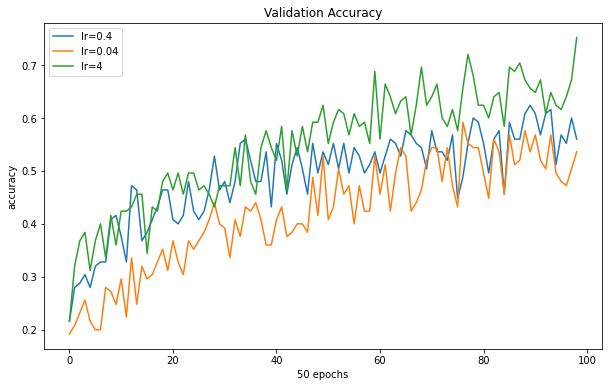

In [ ]:
# draw graphs
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(list(range(len(val_acc_lst1))), val_acc_lst1, label='lr=0.4')
plt.plot(list(range(len(val_acc_lst2))), val_acc_lst2, label='lr=0.04')
plt.plot(list(range(len(val_acc_lst3))), val_acc_lst3, label='lr=4')
plt.title("Validation Accuracy")
plt.xlabel("50 epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [ ]:
# learning inner lr
val_acc_lst4 = run_maml(n_way=5, k_shot=1, inner_update_lr=0.4, num_inner_updates=1, learn_inner_update_lr=True)

Iteration 10: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.20000
Iteration 20: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.20800
Iteration 30: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.19200
Iteration 40: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.19200
Iteration 50: pre-inner-loop train accuracy: 0.22400, post-inner-loop test accuracy: 0.21600
val_acc_lst: 0.2
Meta-validation pre-inner-loop train accuracy: 0.21600, meta-validation post-inner-loop test accuracy: 0.20000
Iteration 60: pre-inner-loop train accuracy: 0.20000, post-inner-loop test accuracy: 0.20800
Iteration 70: pre-inner-loop train accuracy: 0.26400, post-inner-loop test accuracy: 0.24800
Iteration 80: pre-inner-loop train accuracy: 0.19200, post-inner-loop test accuracy: 0.20800
Iteration 90: pre-inner-loop train accuracy: 0.20800, post-inner-loop test accuracy: 0.20800
Iteration 100: pre-inner-loop train

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(list(range(len(val_acc_lst1))), val_acc_lst1, label='lr=0.4')
plt.plot(list(range(len(val_acc_lst2))), val_acc_lst2, label='lr=0.04')
plt.plot(list(range(len(val_acc_lst3))), val_acc_lst3, label='lr=4')
plt.plot(list(range(len(val_acc_lst4))), val_acc_lst4, label='Learning inner lr')
plt.title("Validation Accuracy")
plt.xlabel("50 epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [ ]:
# models/ProtoNet
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

class ProtoNet(tf.keras.Model):

  def __init__(self, num_filters, latent_dim):
    super(ProtoNet, self).__init__()
    self.num_filters = num_filters
    self.latent_dim = latent_dim
    num_filter_list = self.num_filters + [latent_dim]
    self.convs = []
    for i, num_filter in enumerate(num_filter_list):
      block_parts = [
        layers.Conv2D(
          filters=num_filter,
          kernel_size=3,
          padding='SAME',
          activation='linear'),
      ]

      block_parts += [layers.BatchNormalization()]
      block_parts += [layers.Activation('relu')]
      block_parts += [layers.MaxPool2D()]
      block = tf.keras.Sequential(block_parts, name='conv_block_%d' % i)
      self.__setattr__("conv%d" % i, block)
      self.convs.append(block)
    self.flatten = tf.keras.layers.Flatten()

  def call(self, inp):
    out = inp
    for conv in self.convs:
      out = conv(out)
    out = self.flatten(out)
    return out

def ProtoLoss(x_latent, q_latent, labels_onehot, num_classes, num_support, num_queries):
  """
    calculates the prototype network loss using the latent representation of x
    and the latent representation of the query set
    Args:
      x_latent: latent representation of supports with shape [N*S, D], where D is the latent dimension
      q_latent: latent representation of queries with shape [N*Q, D], where D is the latent dimension
      labels_onehot: one-hot encodings of the labels of the queries with shape [N, Q, N]
      num_classes: number of classes (N) for classification
      num_support: number of examples (S) in the support set
      num_queries: number of examples (Q) in the query set
    Returns:
      ce_loss: the cross entropy loss between the predicted labels and true labels
      acc: the accuracy of classification on the queries
  """
  #############################
  #### YOUR CODE GOES HERE ####

  # compute the prototypes (MEAN of support set in embedding space)
  # label align with support set in shape[0], add a noise to prototype to avoid divide by 0
  support_mask = (labels_onehot[0,:,:num_support,:]).reshape((num_classes*num_support, num_classes))
  prototypes = tf.matmul(tf.transpose(support_mask) / num_support, x_latent)
  noise = tf.random.normal(shape=tf.shape(prototypes), mean=0.0, stddev=0.0001, dtype=tf.float32)
  prototypes += noise
  # compute the distance from the prototypes
  # prototypes: [N, D] -> [N*Q, N, D]; q_latent: [N*Q, D] -> [N*Q, N, D]
  a = tf.constant([num_classes*num_queries, 1, 1], tf.int32)
  b = tf.constant([1, num_classes, 1], tf.int32)
  prototype_expand = tf.tile(tf.expand_dims(prototypes, axis=0), a)
  q_latent_expand = tf.tile(tf.expand_dims(q_latent, axis=1), b)
  distance = tf.norm(tf.math.subtract(prototype_expand, q_latent_expand), axis=-1)
  # compute the prediction
  predictions = tf.math.softmax(tf.math.negative(distance))
  # tf.print(tf.math.reduce_mean(predictions))
  # compute cross entropy loss
  # note - additional steps are needed!
  q_labels = labels_onehot[0,:,-num_queries:,:].reshape((num_classes * num_queries, num_classes))
  if predictions.shape != q_labels.shape:
    print("shape diff {}, {}".format(predictions.shape, q_labels.shape))
  # assert predictions.shape == q_labels.shape, "shape diff {}, {}".format(predictions.shape, q_labels.shape)
  ce_loss = cross_entropy_loss(predictions, q_labels, 1)
  m = tf.keras.metrics.CategoricalAccuracy()
  m.update_state(q_labels, predictions)
  acc = m.result()
  # return the cross-entropy loss and accuracy
  #############################
  return ce_loss, acc

In [ ]:
# run_ProtoNet
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import os
import glob
import matplotlib.pyplot as plt

def proto_net_train_step(model, optim, x, q, labels_ph):
  num_classes, num_support, im_height, im_width, channels = x.shape
  num_queries = q.shape[1]
  x = tf.reshape(x, [-1, im_height, im_width, channels])
  q = tf.reshape(q, [-1, im_height, im_width, channels])

  with tf.GradientTape() as tape:
    x_latent = model(x)
    q_latent = model(q)
    ce_loss, acc = ProtoLoss(x_latent, q_latent, labels_ph, num_classes, num_support, num_queries)
    
  gradients = tape.gradient(ce_loss, model.trainable_variables)
  optim.apply_gradients(zip(gradients, model.trainable_variables))
  return ce_loss, acc

def proto_net_eval(model, x, q, labels_ph):
  num_classes, num_support, im_height, im_width, channels = x.shape
  num_queries = q.shape[1]
  x = tf.reshape(x, [-1, im_height, im_width, channels])
  q = tf.reshape(q, [-1, im_height, im_width, channels])

  x_latent = model(x)
  q_latent = model(q)
  ce_loss, acc = ProtoLoss(x_latent, q_latent, labels_ph, num_classes, num_support, num_queries)

  return ce_loss, acc 

def run_protonet(data_path='./omniglot_resized', n_way=20, k_shot=1, n_query=5, n_meta_test_way=20, k_meta_test_shot=5, n_meta_test_query=5):
  n_epochs = 10
  n_episodes = 100

  im_width, im_height, channels = 28, 28, 1
  num_filters = 32
  latent_dim = 16
  num_conv_layers = 3
  n_meta_test_episodes = 1000

  model = ProtoNet([num_filters]*num_conv_layers, latent_dim)
  optimizer = tf.keras.optimizers.Adam()
  val_ac_lst = []
    # call DataGenerator with k_shot+n_query samples per class
    # image batch has shape [B, N, K, 784] and label batch has shape [B, N, K, N]
  data_generator = DataGenerator(n_way, k_shot+n_query, n_meta_test_way, k_meta_test_shot+n_meta_test_query)
  for ep in range(n_epochs):
    for epi in range(n_episodes):
      #############################
      #### YOUR CODE GOES HERE ####

      # sample a batch of training data and partition it into
      # support and query sets
      image, label = data_generator.sample_batch('meta_train', 1, shuffle=False)
      s_flatten, q_flatten = image[:,:,:k_shot,:], image[:,:,k_shot:,:]
      labels = label
      # reshape them into [num_classes, num_support, im_height, im_width, channels]
      support = np.reshape(np.squeeze(s_flatten, axis=0), newshape=(s_flatten.shape[1], s_flatten.shape[2], 
                                                                 im_height, im_height, channels))
      query = np.reshape(np.squeeze(q_flatten, axis=0), newshape=(q_flatten.shape[1], q_flatten.shape[2],
                                                               im_height, im_height, channels))
      #############################
      ls, ac = proto_net_train_step(model, optimizer, x=support, q=query, labels_ph=labels)
      if (epi+1) % 50 == 0:
        #############################
        #### YOUR CODE GOES HERE ####
        # sample a batch of validation data and partition it into
        # support and query sets
        image_val, label_val = data_generator.sample_batch('meta_val', 1, shuffle=True)
        s_flatten, q_flatten = image_val[:,:,:k_shot,:], image_val[:,:,k_shot:,:]
        labels = label_val
        # reshape them into [num_classes, num_support, im_height, im_width, channels]
        support = np.reshape(np.squeeze(s_flatten, axis=0), newshape=(s_flatten.shape[1], s_flatten.shape[2], 
                                                                 im_height, im_height, channels))
        query = np.reshape(np.squeeze(q_flatten, axis=0), newshape=(q_flatten.shape[1], q_flatten.shape[2],
                                                               im_height, im_height, channels))
        #############################
        val_ls, val_ac = proto_net_eval(model, x=support, q=query, labels_ph=labels)
        val_ac_lst.append(val_ac)
        print('[epoch {}/{}, episode {}/{}] => meta-training loss: {:.5f}, meta-training acc: {:.5f}, meta-val loss: {:.5f}, meta-val acc: {:.5f}'.format(ep+1,
                                                                    n_epochs,
                                                                    epi+1,
                                                                    n_episodes,
                                                                    ls,
                                                                    ac,
                                                                    val_ls,
                                                                    val_ac))

  print('Testing...')
  meta_test_accuracies = []
  for epi in range(n_meta_test_episodes):
    #############################
    #### YOUR CODE GOES HERE ####

    # sample a batch of test data and partition it into
    # support and query sets
    image_test, label_test = data_generator.sample_batch('meta_test', 1, shuffle=True)
    s_flatten, q_flatten = image_test[:,:,:k_meta_test_shot,:], image_test[:,:,k_meta_test_shot:,:]
    labels = label_test
    # reshape them into [num_classes, num_support, im_height, im_width, channels]
    support = np.reshape(np.squeeze(s_flatten, axis=0), newshape=(s_flatten.shape[1], s_flatten.shape[2], 
                                                              im_height, im_height, channels))
    query = np.reshape(np.squeeze(q_flatten, axis=0), newshape=(q_flatten.shape[1], q_flatten.shape[2],
                                                            im_height, im_height, channels))
    #############################
    ls, ac = proto_net_eval(model, x=support, q=query, labels_ph=labels)
    meta_test_accuracies.append(ac)
    if (epi+1) % 50 == 0:
      print('[meta-test episode {}/{}] => loss: {:.5f}, acc: {:.5f}'.format(epi+1, n_meta_test_episodes, ls, ac))
  avg_acc = np.mean(meta_test_accuracies)
  stds = np.std(meta_test_accuracies)
  print('Average Meta-Test Accuracy: {:.5f}, Meta-Test Accuracy Std: {:.5f}'.format(avg_acc, stds))
  return val_ac_lst

In [ ]:
val_ac_lst_proto = run_protonet('./omniglot_resized/', n_way=5, k_shot=1, n_query=5, n_meta_test_way=5, k_meta_test_shot=4, n_meta_test_query=4)

In [ ]:
val_ac_lst_digit = [item.numpy() for item in val_ac_lst_proto]
epochs = list(range(len(val_ac_lst_digit)))

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_ac_lst_digit)
plt.xlabel('0.5 epoch')
plt.ylabel('accuracy')
plt.title('Prototypical Network Accuracy')
plt.show()

In [ ]:
protonet('./omniglot resized/')

In [ ]:
# problem 3
# k = 4, 6, 8, 10
run_protonet('./omniglot_resized/', n_way=5, k_shot=1, n_query=5, n_meta_test_way=5, k_meta_test_shot=6, n_meta_test_query=4)

In [ ]:
run_protonet('./omniglot_resized/', n_way=5, k_shot=1, n_query=5, n_meta_test_way=5, k_meta_test_shot=8, n_meta_test_query=4)

In [ ]:
run_protonet('./omniglot_resized/', n_way=5, k_shot=1, n_query=5, n_meta_test_way=5, k_meta_test_shot=10, n_meta_test_query=4)

In [ ]:
maml(n_way=5,k_shot=1,inner_update lr=0.4,num_inner_updates=1)

In [ ]:
run_maml(n_way=5,k_shot=4,inner_update_lr=0.4,num_inner_updates=1,meta_train=False, meta_train_k_shot=1)

In [ ]:
run_maml(n_way=5,k_shot=6,inner_update_lr=0.4,num_inner_updates=1,meta_train=False,meta_train_k_shot=1)

In [ ]:
run_maml(n_way=5,k_shot=8,inner_update_lr=0.4,num_inner_updates=1,meta_train=False,meta_train_k_shot=1)

In [ ]:
run_maml(n_way=5,k_shot=10,inner_update_lr=0.4,num_inner_updates=1,meta_train=False,meta_train_k_shot=1)

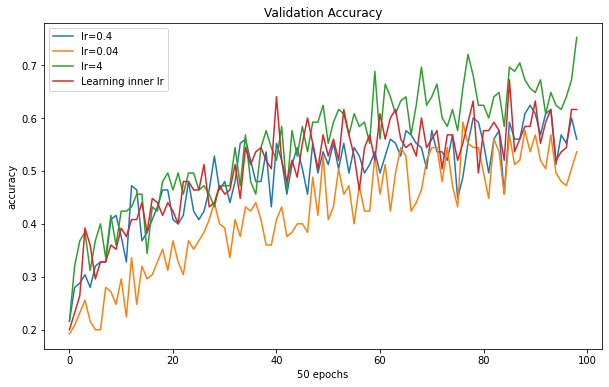

In [ ]:
# models/ProtoNet
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

class ProtoNet(tf.keras.Model):

  def __init__(self, num_filters, latent_dim):
    super(ProtoNet, self).__init__()
    self.num_filters = num_filters
    self.latent_dim = latent_dim
    num_filter_list = self.num_filters + [latent_dim]
    self.convs = []
    for i, num_filter in enumerate(num_filter_list):
      block_parts = [
        layers.Conv2D(
          filters=num_filter,
          kernel_size=3,
          padding='SAME',
          activation='linear'),
      ]

      block_parts += [layers.BatchNormalization()]
      block_parts += [layers.Activation('relu')]
      block_parts += [layers.MaxPool2D()]
      block = tf.keras.Sequential(block_parts, name='conv_block_%d' % i)
      self.__setattr__("conv%d" % i, block)
      self.convs.append(block)
    self.flatten = tf.keras.layers.Flatten()

  def call(self, inp):
    out = inp
    for conv in self.convs:
      out = conv(out)
    out = self.flatten(out)
    return out

def ProtoLoss(x_latent, q_latent, labels_onehot, num_classes, num_support, num_queries):
  """
    calculates the prototype network loss using the latent representation of x
    and the latent representation of the query set
    Args:
      x_latent: latent representation of supports with shape [N*S, D], where D is the latent dimension
      q_latent: latent representation of queries with shape [N*Q, D], where D is the latent dimension
      labels_onehot: one-hot encodings of the labels of the queries with shape [N, Q, N]
      num_classes: number of classes (N) for classification
      num_support: number of examples (S) in the support set
      num_queries: number of examples (Q) in the query set
    Returns:
      ce_loss: the cross entropy loss between the predicted labels and true labels
      acc: the accuracy of classification on the queries
  """
  #############################
  #### YOUR CODE GOES HERE ####

  # compute the prototypes (MEAN of support set in embedding space)
  # label align with support set in shape[0], add a noise to prototype to avoid divide by 0
  support_mask = (labels_onehot[0,:,:num_support,:]).reshape((num_classes*num_support, num_classes))
  prototypes = tf.matmul(tf.transpose(support_mask) / num_support, x_latent)
  noise = tf.random.normal(shape=tf.shape(prototypes), mean=0.0, stddev=0.0001, dtype=tf.float32)
  prototypes += noise
  # compute the distance from the prototypes
  # prototypes: [N, D] -> [N*Q, N, D]; q_latent: [N*Q, D] -> [N*Q, N, D]
  a = tf.constant([num_classes*num_queries, 1, 1], tf.int32)
  b = tf.constant([1, num_classes, 1], tf.int32)
  prototype_expand = tf.tile(tf.expand_dims(prototypes, axis=0), a)
  q_latent_expand = tf.tile(tf.expand_dims(q_latent, axis=1), b)
  distance = tf.norm(tf.math.subtract(prototype_expand, q_latent_expand), axis=-1)
  # compute the prediction
  predictions = tf.math.softmax(tf.math.negative(distance))
  # tf.print(tf.math.reduce_mean(predictions))
  # compute cross entropy loss
  # note - additional steps are needed!
  q_labels = labels_onehot[0,:,-num_queries:,:].reshape((num_classes * num_queries, num_classes))
  if predictions.shape != q_labels.shape:
    print("shape diff {}, {}".format(predictions.shape, q_labels.shape))
  # assert predictions.shape == q_labels.shape, "shape diff {}, {}".format(predictions.shape, q_labels.shape)
  ce_loss = cross_entropy_loss(predictions, q_labels, 1)
  m = tf.keras.metrics.CategoricalAccuracy()
  m.update_state(q_labels, predictions)
  acc = m.result()
  # return the cross-entropy loss and accuracy
  #############################
  return ce_loss, acc

In [ ]:
# run_ProtoNet
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import os
import glob
import matplotlib.pyplot as plt

def proto_net_train_step(model, optim, x, q, labels_ph):
  num_classes, num_support, im_height, im_width, channels = x.shape
  num_queries = q.shape[1]
  x = tf.reshape(x, [-1, im_height, im_width, channels])
  q = tf.reshape(q, [-1, im_height, im_width, channels])

  with tf.GradientTape() as tape:
    x_latent = model(x)
    q_latent = model(q)
    ce_loss, acc = ProtoLoss(x_latent, q_latent, labels_ph, num_classes, num_support, num_queries)
    
  gradients = tape.gradient(ce_loss, model.trainable_variables)
  optim.apply_gradients(zip(gradients, model.trainable_variables))
  return ce_loss, acc

def proto_net_eval(model, x, q, labels_ph):
  num_classes, num_support, im_height, im_width, channels = x.shape
  num_queries = q.shape[1]
  x = tf.reshape(x, [-1, im_height, im_width, channels])
  q = tf.reshape(q, [-1, im_height, im_width, channels])

  x_latent = model(x)
  q_latent = model(q)
  ce_loss, acc = ProtoLoss(x_latent, q_latent, labels_ph, num_classes, num_support, num_queries)

  return ce_loss, acc 

def run_protonet(data_path='./omniglot_resized', n_way=20, k_shot=1, n_query=5, n_meta_test_way=20, k_meta_test_shot=5, n_meta_test_query=5):
  n_epochs = 10
  n_episodes = 100

  im_width, im_height, channels = 28, 28, 1
  num_filters = 32
  latent_dim = 16
  num_conv_layers = 3
  n_meta_test_episodes = 1000

  model = ProtoNet([num_filters]*num_conv_layers, latent_dim)
  optimizer = tf.keras.optimizers.Adam()
  val_ac_lst = []
    # call DataGenerator with k_shot+n_query samples per class
    # image batch has shape [B, N, K, 784] and label batch has shape [B, N, K, N]
  data_generator = DataGenerator(n_way, k_shot+n_query, n_meta_test_way, k_meta_test_shot+n_meta_test_query)
  for ep in range(n_epochs):
    for epi in range(n_episodes):
      #############################
      #### YOUR CODE GOES HERE ####

      # sample a batch of training data and partition it into
      # support and query sets
      image, label = data_generator.sample_batch('meta_train', 1, shuffle=False)
      s_flatten, q_flatten = image[:,:,:k_shot,:], image[:,:,k_shot:,:]
      labels = label
      # reshape them into [num_classes, num_support, im_height, im_width, channels]
      support = np.reshape(np.squeeze(s_flatten, axis=0), newshape=(s_flatten.shape[1], s_flatten.shape[2], 
                                                                 im_height, im_height, channels))
      query = np.reshape(np.squeeze(q_flatten, axis=0), newshape=(q_flatten.shape[1], q_flatten.shape[2],
                                                               im_height, im_height, channels))
      #############################
      ls, ac = proto_net_train_step(model, optimizer, x=support, q=query, labels_ph=labels)
      if (epi+1) % 50 == 0:
        #############################
        #### YOUR CODE GOES HERE ####
        # sample a batch of validation data and partition it into
        # support and query sets
        image_val, label_val = data_generator.sample_batch('meta_val', 1, shuffle=True)
        s_flatten, q_flatten = image_val[:,:,:k_shot,:], image_val[:,:,k_shot:,:]
        labels = label_val
        # reshape them into [num_classes, num_support, im_height, im_width, channels]
        support = np.reshape(np.squeeze(s_flatten, axis=0), newshape=(s_flatten.shape[1], s_flatten.shape[2], 
                                                                 im_height, im_height, channels))
        query = np.reshape(np.squeeze(q_flatten, axis=0), newshape=(q_flatten.shape[1], q_flatten.shape[2],
                                                               im_height, im_height, channels))
        #############################
        val_ls, val_ac = proto_net_eval(model, x=support, q=query, labels_ph=labels)
        val_ac_lst.append(val_ac)
        print('[epoch {}/{}, episode {}/{}] => meta-training loss: {:.5f}, meta-training acc: {:.5f}, meta-val loss: {:.5f}, meta-val acc: {:.5f}'.format(ep+1,
                                                                    n_epochs,
                                                                    epi+1,
                                                                    n_episodes,
                                                                    ls,
                                                                    ac,
                                                                    val_ls,
                                                                    val_ac))

  print('Testing...')
  meta_test_accuracies = []
  for epi in range(n_meta_test_episodes):
    #############################
    #### YOUR CODE GOES HERE ####

    # sample a batch of test data and partition it into
    # support and query sets
    image_test, label_test = data_generator.sample_batch('meta_test', 1, shuffle=True)
    s_flatten, q_flatten = image_test[:,:,:k_meta_test_shot,:], image_test[:,:,k_meta_test_shot:,:]
    labels = label_test
    # reshape them into [num_classes, num_support, im_height, im_width, channels]
    support = np.reshape(np.squeeze(s_flatten, axis=0), newshape=(s_flatten.shape[1], s_flatten.shape[2], 
                                                              im_height, im_height, channels))
    query = np.reshape(np.squeeze(q_flatten, axis=0), newshape=(q_flatten.shape[1], q_flatten.shape[2],
                                                            im_height, im_height, channels))
    #############################
    ls, ac = proto_net_eval(model, x=support, q=query, labels_ph=labels)
    meta_test_accuracies.append(ac)
    if (epi+1) % 50 == 0:
      print('[meta-test episode {}/{}] => loss: {:.5f}, acc: {:.5f}'.format(epi+1, n_meta_test_episodes, ls, ac))
  avg_acc = np.mean(meta_test_accuracies)
  stds = np.std(meta_test_accuracies)
  print('Average Meta-Test Accuracy: {:.5f}, Meta-Test Accuracy Std: {:.5f}'.format(avg_acc, stds))
  return val_ac_lst

In [ ]:
val_ac_lst_proto = run_protonet('./omniglot_resized/', n_way=5, k_shot=1, n_query=5, n_meta_test_way=5, k_meta_test_shot=4, n_meta_test_query=4)

[epoch 1/10, episode 50/100] => meta-training loss: 1.37393, meta-training acc: 0.48000, meta-val loss: 1.23199, meta-val acc: 0.68000
[epoch 1/10, episode 100/100] => meta-training loss: 1.05177, meta-training acc: 0.84000, meta-val loss: 1.25388, meta-val acc: 0.64000
[epoch 2/10, episode 50/100] => meta-training loss: 1.03817, meta-training acc: 0.88000, meta-val loss: 1.14580, meta-val acc: 0.80000
[epoch 2/10, episode 100/100] => meta-training loss: 1.24077, meta-training acc: 0.60000, meta-val loss: 1.14728, meta-val acc: 0.80000
[epoch 3/10, episode 50/100] => meta-training loss: 1.19737, meta-training acc: 0.68000, meta-val loss: 1.17831, meta-val acc: 0.76000
[epoch 3/10, episode 100/100] => meta-training loss: 0.97804, meta-training acc: 0.92000, meta-val loss: 0.96317, meta-val acc: 0.96000
[epoch 4/10, episode 50/100] => meta-training loss: 1.14092, meta-training acc: 0.80000, meta-val loss: 1.10358, meta-val acc: 0.80000
[epoch 4/10, episode 100/100] => meta-training loss:

In [ ]:
val_ac_lst_digit = [item.numpy() for item in val_ac_lst_proto]
epochs = list(range(len(val_ac_lst_digit)))

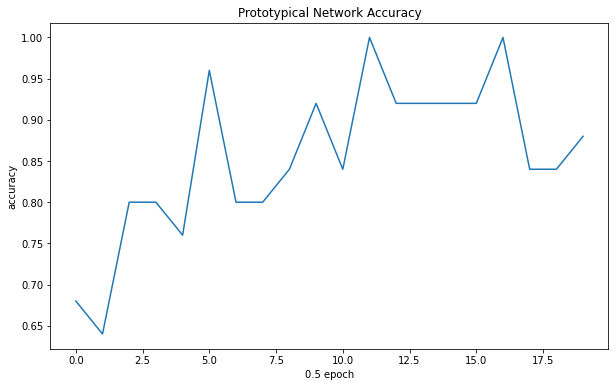

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_ac_lst_digit)
plt.xlabel('0.5 epoch')
plt.ylabel('accuracy')
plt.title('Prototypical Network Accuracy')
plt.show()

In [ ]:
protonet('./omniglot resized/')

In [ ]:
# problem 3
# k = 4, 6, 8, 10
run_protonet('./omniglot_resized/', n_way=5, k_shot=1, n_query=5, n_meta_test_way=5, k_meta_test_shot=6, n_meta_test_query=4)

[epoch 1/10, episode 50/100] => meta-training loss: 1.45041, meta-training acc: 0.44000, meta-val loss: 1.01855, meta-val acc: 0.88000
[epoch 1/10, episode 100/100] => meta-training loss: 1.29000, meta-training acc: 0.52000, meta-val loss: 1.19780, meta-val acc: 0.72000
[epoch 2/10, episode 50/100] => meta-training loss: 0.99563, meta-training acc: 0.88000, meta-val loss: 1.21242, meta-val acc: 0.68000
[epoch 2/10, episode 100/100] => meta-training loss: 1.24793, meta-training acc: 0.64000, meta-val loss: 1.35914, meta-val acc: 0.48000
[epoch 3/10, episode 50/100] => meta-training loss: 1.43714, meta-training acc: 0.48000, meta-val loss: 1.26139, meta-val acc: 0.64000
[epoch 3/10, episode 100/100] => meta-training loss: 1.08285, meta-training acc: 0.88000, meta-val loss: 1.01039, meta-val acc: 0.88000
[epoch 4/10, episode 50/100] => meta-training loss: 1.14013, meta-training acc: 0.76000, meta-val loss: 1.24643, meta-val acc: 0.64000
[epoch 4/10, episode 100/100] => meta-training loss:

[<tf.Tensor: shape=(), dtype=float32, numpy=0.88>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.72>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.68>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.48>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.64>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.88>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.64>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.68>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.84>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.96>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.88>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.8>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.8>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.72>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.68>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.84>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.88>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.92>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.76>,
 <tf.Tensor: shape=(), dtype=floa

In [ ]:
run_protonet('./omniglot_resized/', n_way=5, k_shot=1, n_query=5, n_meta_test_way=5, k_meta_test_shot=8, n_meta_test_query=4)

[epoch 1/10, episode 50/100] => meta-training loss: 1.45503, meta-training acc: 0.44000, meta-val loss: 0.99504, meta-val acc: 0.96000
[epoch 1/10, episode 100/100] => meta-training loss: 1.28161, meta-training acc: 0.56000, meta-val loss: 1.21121, meta-val acc: 0.72000
[epoch 2/10, episode 50/100] => meta-training loss: 0.98008, meta-training acc: 0.92000, meta-val loss: 1.26791, meta-val acc: 0.64000
[epoch 2/10, episode 100/100] => meta-training loss: 1.24685, meta-training acc: 0.68000, meta-val loss: 1.36765, meta-val acc: 0.52000
[epoch 3/10, episode 50/100] => meta-training loss: 1.40375, meta-training acc: 0.52000, meta-val loss: 1.28296, meta-val acc: 0.64000
[epoch 3/10, episode 100/100] => meta-training loss: 1.03393, meta-training acc: 0.88000, meta-val loss: 1.26064, meta-val acc: 0.60000
[epoch 4/10, episode 50/100] => meta-training loss: 1.23088, meta-training acc: 0.68000, meta-val loss: 1.33566, meta-val acc: 0.56000
[epoch 4/10, episode 100/100] => meta-training loss:

[<tf.Tensor: shape=(), dtype=float32, numpy=0.96>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.72>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.64>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.52>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.64>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.56>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.8>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.8>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.96>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.88>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.84>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.76>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.72>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.88>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.96>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.72>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.68>,
 <tf.Tensor: shape=(), dtype=float3

In [ ]:
run_protonet('./omniglot_resized/', n_way=5, k_shot=1, n_query=5, n_meta_test_way=5, k_meta_test_shot=10, n_meta_test_query=4)

[epoch 1/10, episode 50/100] => meta-training loss: 1.38808, meta-training acc: 0.40000, meta-val loss: 0.98500, meta-val acc: 0.92000
[epoch 1/10, episode 100/100] => meta-training loss: 1.23098, meta-training acc: 0.64000, meta-val loss: 1.13874, meta-val acc: 0.72000
[epoch 2/10, episode 50/100] => meta-training loss: 0.97855, meta-training acc: 0.96000, meta-val loss: 1.15329, meta-val acc: 0.80000
[epoch 2/10, episode 100/100] => meta-training loss: 1.20167, meta-training acc: 0.72000, meta-val loss: 1.36705, meta-val acc: 0.48000
[epoch 3/10, episode 50/100] => meta-training loss: 1.45735, meta-training acc: 0.44000, meta-val loss: 1.27224, meta-val acc: 0.64000
[epoch 3/10, episode 100/100] => meta-training loss: 1.05696, meta-training acc: 0.88000, meta-val loss: 1.14911, meta-val acc: 0.68000
[epoch 4/10, episode 50/100] => meta-training loss: 1.24837, meta-training acc: 0.64000, meta-val loss: 1.24665, meta-val acc: 0.64000
[epoch 4/10, episode 100/100] => meta-training loss:

[<tf.Tensor: shape=(), dtype=float32, numpy=0.92>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.72>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.8>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.48>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.64>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.68>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.64>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.76>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.8>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.92>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.92>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.8>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.8>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.76>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.64>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.84>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.88>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.84>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.76>,
 <tf.Tensor: shape=(), dtype=float3

In [ ]:
maml(n_way=5,k_shot=1,inner_update lr=0.4,num_inner_updates=1)

In [ ]:
run_maml(n_way=5,k_shot=4,inner_update_lr=0.4,num_inner_updates=1,meta_train=False, meta_train_k_shot=1)

Restoring model weights from  /tmp/data/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.4.learn_inner_update_lr_False/model4999
Mean meta-test accuracy/loss, stddev, and confidence intervals
(0.6449167, 0.14219703, 0.011378131927842339)


UnboundLocalError: ignored

In [ ]:
run_maml(n_way=5,k_shot=6,inner_update_lr=0.4,num_inner_updates=1,meta_train=False,meta_train_k_shot=1)

Restoring model weights from  /tmp/data/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.4.learn_inner_update_lr_False/model4999
Mean meta-test accuracy/loss, stddev, and confidence intervals
(0.5950555, 0.1491693, 0.011936029578111625)


UnboundLocalError: ignored

In [ ]:
run_maml(n_way=5,k_shot=8,inner_update_lr=0.4,num_inner_updates=1,meta_train=False,meta_train_k_shot=1)

Restoring model weights from  /tmp/data/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.4.learn_inner_update_lr_False/model4999
Mean meta-test accuracy/loss, stddev, and confidence intervals
(0.549375, 0.14729726, 0.011786235750350345)


UnboundLocalError: ignored

In [ ]:
run_maml(n_way=5,k_shot=10,inner_update_lr=0.4,num_inner_updates=1,meta_train=False,meta_train_k_shot=1)

Restoring model weights from  /tmp/data/cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.4.learn_inner_update_lr_False/model4999
Mean meta-test accuracy/loss, stddev, and confidence intervals
(0.51316667, 0.13652584, 0.010924342359059548)


UnboundLocalError: ignored